In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

       battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715     0.288416    35.399655     2.287837  ...   
min       0.00000

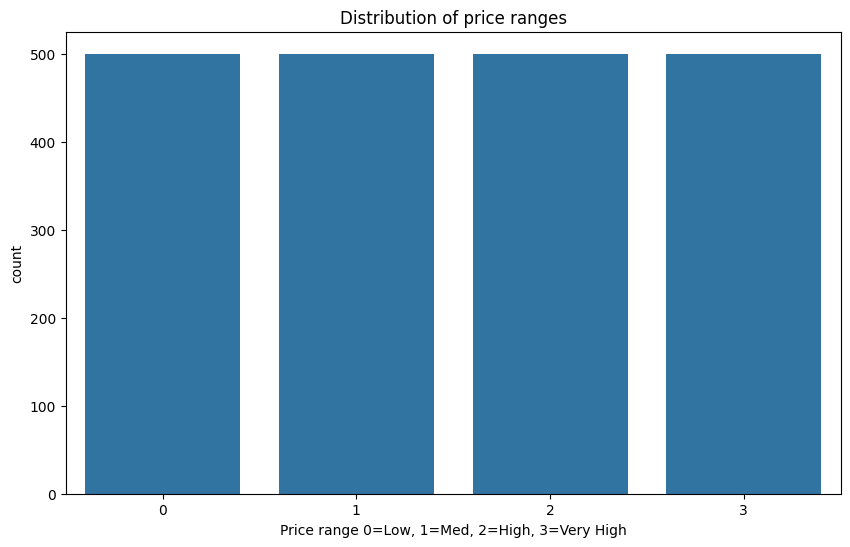

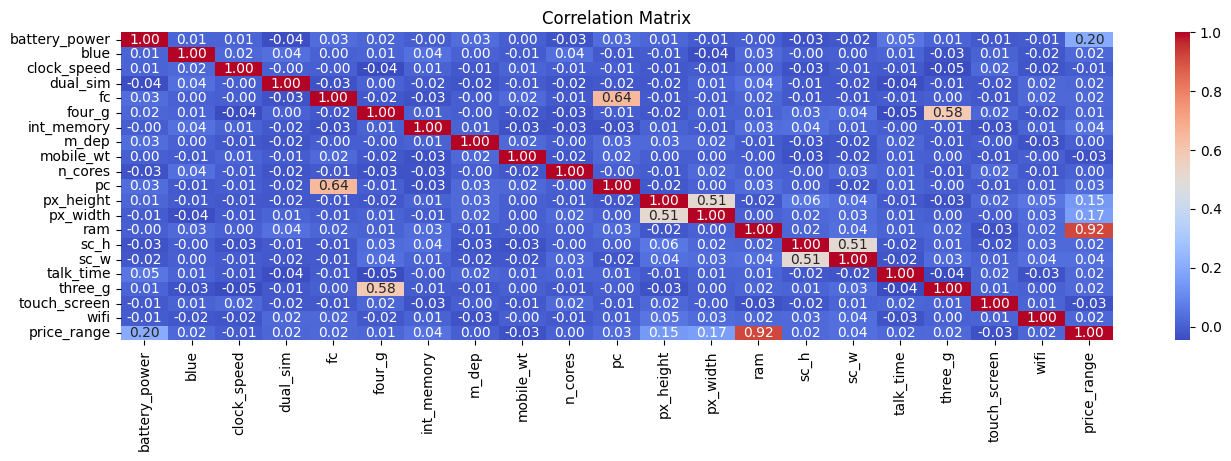

Feature correlation with price range
price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64


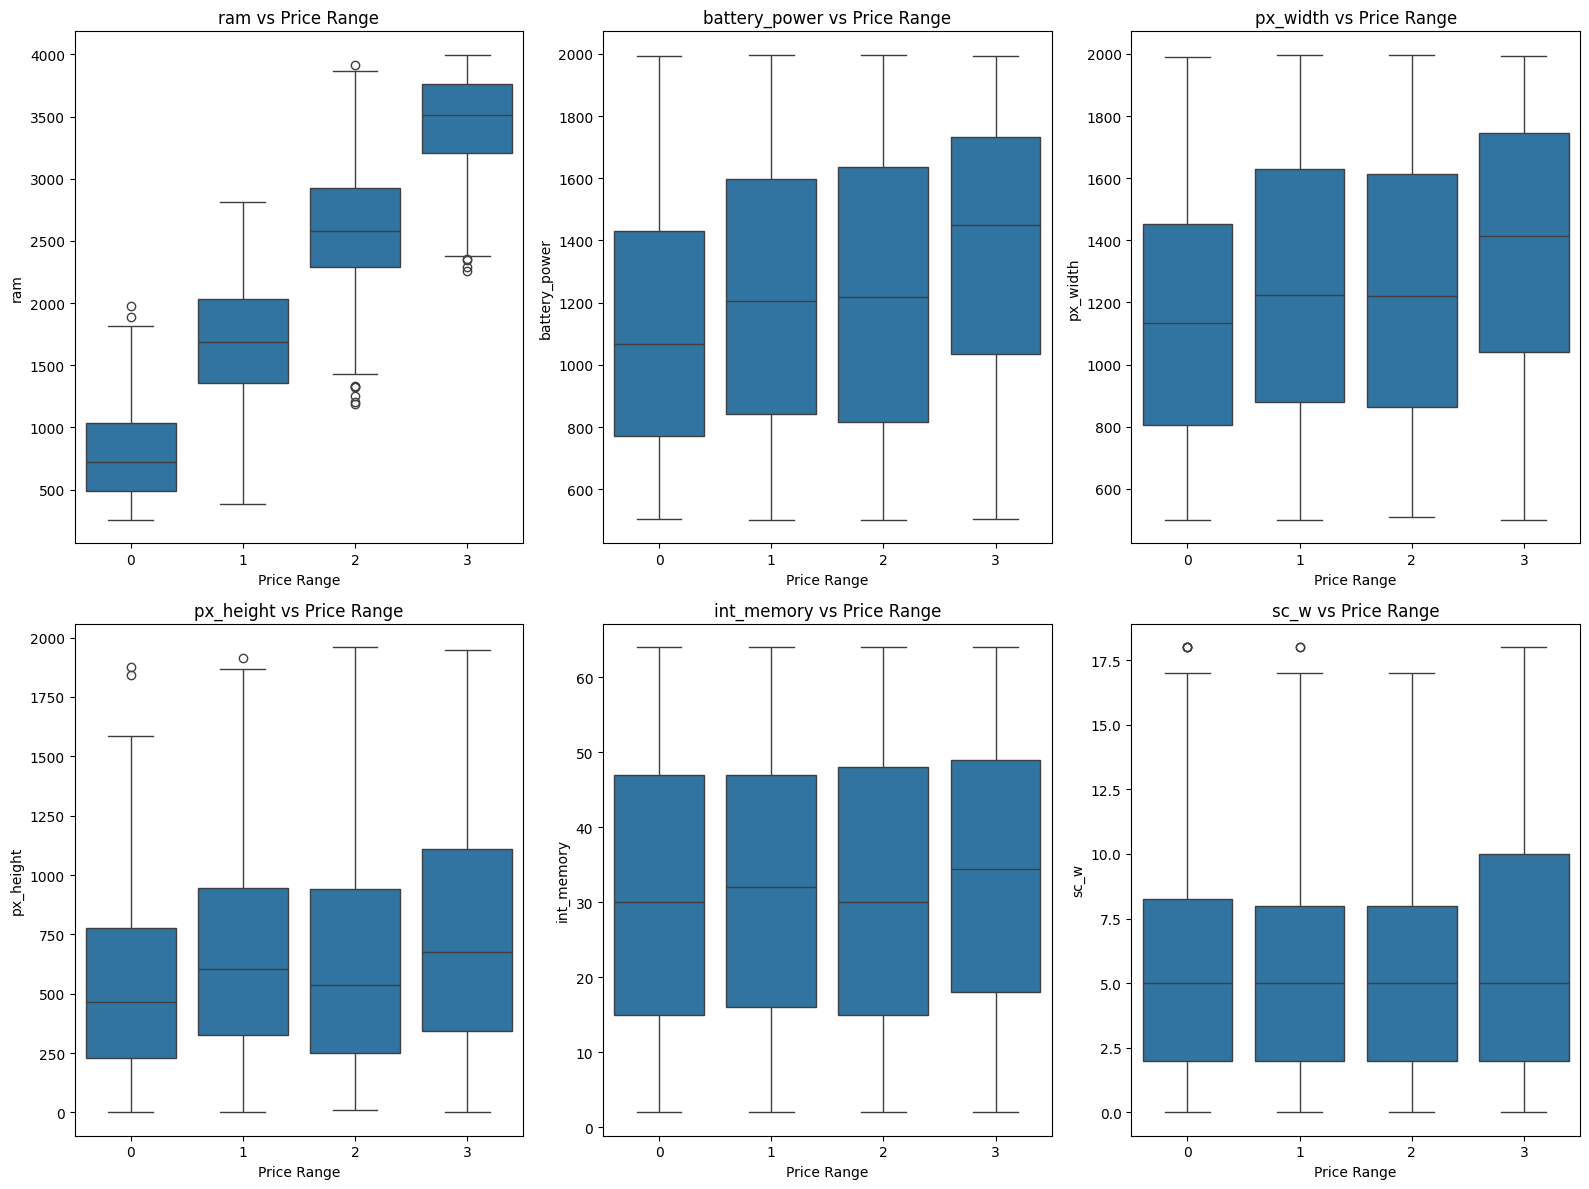

Data ranges before scaling:
Train data min: 0.0, max: 1920247559.9999998
Scaling successful.
Results
--------------------------------------------------
Logistic Regression  - Mean Accuracy: 0.9406, Std: 0.0091
Random Forest        - Mean Accuracy: 0.8631, Std: 0.0091
Gradient Boosting    - Mean Accuracy: 0.8856, Std: 0.0136
SVM                  - Mean Accuracy: 0.8387, Std: 0.0273
KNN                  - Mean Accuracy: 0.4944, Std: 0.0345

Best model: Logistic Regression with accuracy 0.9406

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.9606
Final Model Accuracy: 0.9725
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.98      0.95      0.96       100
           2       0.95      0.96      0.96       100
           3       0.98      0.98      0.98   

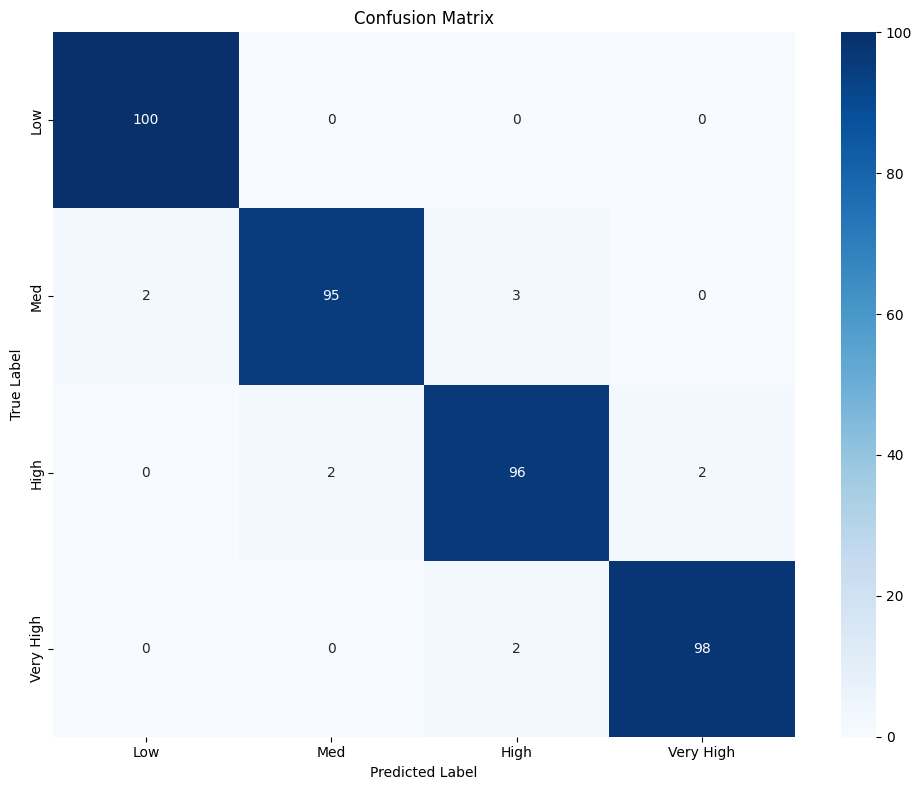

Model saved to mobile_price_model.pkl and scaler saved to feature_scaler.pkl

Prediction for new phone:
Predicted price range: 0 (Low)
Prediction probabilities:
  Low: 1.0000
  Med: 0.0000
  High: 0.0000
  Very High: 0.0000


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

class MobilePricePredictor:
    def __init__(self, df=None):
        self.df = df
        self.model = None  # Fixed: changed 'modal' to 'model'
        self.scaler = None  # Fixed: changed 'scalar' to 'scaler'
        self.price_ranges = {0: "Low", 1: 'Med', 2: "High", 3: "Very High"}

    def load_data(self, file_path):
        self.df = pd.read_csv(file_path)
        return self
    
    def explore_data(self):
        if self.df is None or len(self.df) < 10:
            print("Not enough data for meaningful exploration. Please load a larger dataset.")
            return
        
        print(self.df.describe())
        # price range distribution
        print(self.df['price_range'].value_counts())

        # plot price range distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='price_range', data=self.df)
        plt.title("Distribution of price ranges")
        plt.xlabel("Price range 0=Low, 1=Med, 2=High, 3=Very High")
        plt.ylabel("count")
        plt.show()

        # correlation analysis
        plt.figure(figsize=(16, 4))
        cor_matrix = self.df.corr()
        sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title("Correlation Matrix")
        plt.show()

        # Feature correlation with price range
        price_cor = cor_matrix['price_range'].sort_values(ascending=False)
        print("Feature correlation with price range")
        print(price_cor)

        # visualize top features with price range
        top_feat = price_cor.index[1:7]
        plt.figure(figsize=(16, 12))
        for i, feature in enumerate(top_feat):
            plt.subplot(2, 3, i+1)
            sns.boxplot(x='price_range', y=feature, data=self.df)
            plt.title(f'{feature} vs Price Range')
            plt.xlabel("Price Range")
            plt.ylabel(feature)

        plt.tight_layout()
        plt.show()

        return self
    
    def feature_engineering(self):
        if self.df is None:
            print("No data available")
            return self
        # screen size
        self.df['screen_area'] = self.df['sc_h'] * self.df['sc_w']
        # Ensure screen_area is not zero before division
        self.df['screen_area'] = self.df['screen_area'].replace(0, 0.001)  # Prevent division by zero
        
        # pixel density - handle potential infinity by capping values
        self.df['pixel_density'] = self.df['px_height'] * self.df['px_width'] / self.df['screen_area']
        # Replace infinity values with a large finite number
        self.df.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)
        
        # Battery
        self.df['battery_eff'] = self.df['battery_power'] / self.df['mobile_wt'].replace(0, 0.001)  # Prevent division by zero
        
        # Performance
        self.df['performance_index'] = self.df['n_cores'] * self.df['clock_speed'] * (self.df['ram'] / 1000)
        
        # camera quality
        self.df['camera_quality'] = self.df['pc'] + self.df['fc']
        
        # Check for and handle any remaining NaN values
        self.df.fillna(self.df.mean(), inplace=True)

        return self
    
    def prepare_data(self, test_size=0.2, random_state=42):
        if self.df is None:
            print("No data available")
            return self
         
        # Final check for problematic values before splitting
        self.df.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)
        self.df.fillna(self.df.mean(), inplace=True)
        
        # Check for and remove any columns with excessive values
        for col in self.df.columns:
            if col != 'price_range':  # Don't modify the target variable
                # Cap extreme values at 99th percentile
                q99 = self.df[col].quantile(0.99)
                self.df[col] = np.where(self.df[col] > q99, q99, self.df[col])
         
        X = self.df.drop('price_range', axis=1)
        y = self.df['price_range']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

        # Check data ranges before scaling
        print("Data ranges before scaling:")
        print(f"Train data min: {self.X_train.min().min()}, max: {self.X_train.max().max()}")
        
        # Scale features with robust handling
        self.scaler = StandardScaler(with_mean=True, with_std=True)
        
        # Convert to numpy arrays for more controlled scaling
        X_train_np = self.X_train.to_numpy()
        X_test_np = self.X_test.to_numpy()
        
        try:
            self.X_train_scaled = self.scaler.fit_transform(X_train_np)
            self.X_test_scaled = self.scaler.transform(X_test_np)
            print("Scaling successful.")
        except Exception as e:
            print(f"Error during scaling: {e}")
            # Fallback to simpler scaling method
            print("Using fallback scaling method...")
            # Min-max scaling using pandas for more control
            for column in self.X_train.columns:
                min_val = self.X_train[column].min()
                max_val = self.X_train[column].max()
                range_val = max_val - min_val if max_val > min_val else 1
                
                # Apply scaling manually
                self.X_train[column] = (self.X_train[column] - min_val) / range_val
                self.X_test[column] = (self.X_test[column] - min_val) / range_val
            
            # Convert to numpy arrays for model compatibility
            self.X_train_scaled = self.X_train.to_numpy()
            self.X_test_scaled = self.X_test.to_numpy()
            print("Fallback scaling completed.")

        self.feature_names = X.columns
        return self
    
    def evaluate_models(self):  # Fixed: changed 'evaluate_modal' to 'evaluate_models'
        if not hasattr(self, 'X_train_scaled'):
            print("Data not prepared")
            return self
         
        models = {  # Fixed: changed 'models' to 'models'
            'Logistic Regression': LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs'),
            'Random Forest': RandomForestClassifier(random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'SVM': SVC(probability=True),
            'KNN': KNeighborsClassifier()
        }
         
        results = {}  # Fixed: changed 'result' to 'results'
        print("Results")  # Fixed: changed 'Result' to 'Results'
        print("-" * 50)

        for name, model in models.items():  # Fixed: changed 'modal' to 'model'
            scores = cross_val_score(model, self.X_train_scaled, self.y_train, cv=5, scoring='accuracy')
            results[name] = scores.mean()
            print(f"{name:20} - Mean Accuracy: {scores.mean():.4f}, Std: {scores.std():.4f}")

        # Identifying best model
        best_model_name = max(results, key=results.get)  # Fixed: changed variable names
        print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]:.4f}")
        self.best_model_name = best_model_name  # Fixed: changed 'best_modal_name' to 'best_model_name'
        return self
    
    def tune_hyperparameters(self):
        if not hasattr(self, 'best_model_name'):  # Fixed: changed 'best_modal_name' to 'best_model_name'
            print("Best model not identified")
            return self
        print(f"\nTuning hyperparameters for {self.best_model_name}...")  # Fixed: changed 'best_modal_name' to 'best_model_name'

        param_grids = {
            'Logistic Regression': {
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['lbfgs', 'newton-cg', 'sag'],
                'penalty': ['l2']
            },
            'Random Forest': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'Gradient Boosting': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.8, 0.9, 1.0]
            },
            'SVM': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.1, 0.01],
                'kernel': ['rbf', 'poly', 'sigmoid']
            },
            'KNN': {
                'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]  # Manhattan (p=1) or Euclidean (p=2) distance
            }
        }

        if self.best_model_name == 'Logistic Regression':  # Fixed: changed 'best_modal_name' to 'best_model_name'
            model = LogisticRegression(max_iter=2000, multi_class='multinomial')  # Fixed: changed 'modal' to 'model'
        elif self.best_model_name == 'Random Forest':  # Fixed: changed 'best_modal_name' to 'best_model_name'
            model = RandomForestClassifier(random_state=42)  # Fixed: changed 'modal' to 'model'
        elif self.best_model_name == 'Gradient Boosting':  # Fixed: changed 'best_modal_name' to 'best_model_name'
            model = GradientBoostingClassifier(random_state=42)  # Fixed: changed 'modal' to 'model'
        elif self.best_model_name == 'SVM':  # Fixed: changed 'best_modal_name' to 'best_model_name'
            model = SVC(probability=True)  # Fixed: changed 'modal' to 'model'
        elif self.best_model_name == 'KNN':  # Fixed: changed 'best_modal_name' to 'best_model_name'
            model = KNeighborsClassifier()  # Fixed: changed 'modal' to 'model'
        else:
            print(f"Model {self.best_model_name} not recognized.")  # Fixed: changed 'best_model_name' to 'best_model_name'
            return self
         
        param_grid = param_grids[self.best_model_name]  # Fixed: changed 'best_modal_name' to 'best_model_name'
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)  # Fixed: changed 'modal' to 'model'
        grid_search.fit(self.X_train_scaled, self.y_train)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        self.model = grid_search.best_estimator_  # Fixed: changed 'modal' to 'model'
        return self
    
    def evaluate_final_model(self):  # Fixed: changed 'evaluate_final_modal' to 'evaluate_final_model'
        if self.model is None:  # Fixed: changed 'modal' to 'model'
            print("Model not trained")
            return self
        y_predictions = self.model.predict(self.X_test_scaled)  # Fixed: changed 'modal' to 'model'

        accuracy = accuracy_score(self.y_test, y_predictions)
        print(f'Final Model Accuracy: {accuracy:.4f}')  # Fixed: changed 'Financial Modal' to 'Final Model'

        print(classification_report(self.y_test, y_predictions))

        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(self.y_test, y_predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.price_ranges.values(), yticklabels=self.price_ranges.values())
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        if hasattr(self.model, 'feature_importances_'):  # Fixed: changed 'modal' to 'model'
            feature_importance = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': self.model.feature_importances_  # Fixed: changed 'modal' to 'model'
            }).sort_values(by='Importance', ascending=False)

            print(feature_importance)

            plt.figure(figsize=(12, 8))
            top_n = min(15, len(feature_importance))
            sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))  # Fixed: corrected barplot syntax
            plt.title(f'Top {top_n} Feature Importance')  # Fixed: corrected title
            plt.tight_layout()
            plt.show()
        return self

    def save_model(self, model_path='mobile_price_model.pkl', scaler_path='feature_scaler.pkl'):  # Fixed: changed 'savemodel' to 'save_model'
        if self.model is None or self.scaler is None:  # Fixed: changed 'modal' to 'model' and 'scalar' to 'scaler'
            print("Model not available")
            return self
         
        joblib.dump(self.model, model_path)  # Fixed: changed 'modal' to 'model'
        joblib.dump(self.scaler, scaler_path)  # Fixed: changed 'scalar' to 'scaler'
        print(f'Model saved to {model_path} and scaler saved to {scaler_path}')  # Fixed: improved print statement
        return self
    
    def load_model(self, model_path='mobile_price_model.pkl', scaler_path='feature_scaler.pkl'):  # Fixed: changed 'loadmodel' to 'load_model'
        self.model = joblib.load(model_path)  # Fixed: changed 'modal' to 'model'
        self.scaler = joblib.load(scaler_path)  # Fixed: changed 'scalar' to 'scaler'
        return self
    
    def predict_price_range(self, features_dict):
        if self.model is None or self.scaler is None:
            print("Model or scaler is not available")
            return None
         
        new_phone = pd.DataFrame([features_dict])
         
        # Apply feature engineering safely
        if 'screen_area' in self.feature_names and 'screen_area' not in new_phone.columns:
            # Calculate engineered features with safeguards
            new_phone['screen_area'] = new_phone['sc_h'] * new_phone['sc_w']
            new_phone['screen_area'] = new_phone['screen_area'].replace(0, 0.001)  # Prevent division by zero
            
            # Handle potential infinity in pixel density calculation
            new_phone['pixel_density'] = new_phone['px_height'] * new_phone['px_width'] / new_phone['screen_area']
            new_phone.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)
            
            # Safe division for battery efficiency
            new_phone['battery_eff'] = new_phone['battery_power'] / new_phone['mobile_wt'].replace(0, 0.001)
            
            new_phone['performance_index'] = new_phone['n_cores'] * new_phone['clock_speed'] * (new_phone['ram'] / 1000)
            new_phone['camera_quality'] = new_phone['pc'] + new_phone['fc']
            
            # Fill any NaN values with zeros
            new_phone.fillna(0, inplace=True)
        
        # Check for missing columns
        missing_cols = set(self.feature_names) - set(new_phone.columns)
        for col in missing_cols:
            new_phone[col] = 0
              
        # Ensure columns are in the right order
        new_phone = new_phone[self.feature_names]
        
        # Check for extreme values and cap them
        for col in new_phone.columns:
            max_val = np.finfo(np.float64).max / 1e10  # Set a reasonable upper limit
            new_phone[col] = new_phone[col].clip(upper=max_val)
        
        try:
            # Scale the features
            new_phone_scaled = self.scaler.transform(new_phone)
            prediction = self.model.predict(new_phone_scaled)[0]
            probabilities = self.model.predict_proba(new_phone_scaled)[0]
            
        except Exception as e:
            print(f"Error during prediction: {e}")
            print("Using fallback prediction method...")
            
            # Manual scaling as fallback
            for column in new_phone.columns:
                # Get scaling parameters from the scaler if possible
                try:
                    mean = self.scaler.mean_[list(self.feature_names).index(column)]
                    scale = self.scaler.scale_[list(self.feature_names).index(column)]
                    new_phone[column] = (new_phone[column] - mean) / scale
                except:
                    # Use reasonable defaults if scaler parameters are not available
                    new_phone[column] = (new_phone[column] - new_phone[column].mean()) / (new_phone[column].std() or 1)
            
            # Make prediction with manually scaled data
            try:
                new_phone_scaled = new_phone.to_numpy()
                prediction = self.model.predict(new_phone_scaled)[0]
                probabilities = self.model.predict_proba(new_phone_scaled)[0]
            except:
                # Last resort: return a default prediction
                print("Failed to make prediction. Returning default values.")
                return {
                    'predicted_class': 1,
                    'predicted_label': self.price_ranges[1],  # Medium price as default
                    'probabilities': {label: 0.25 for label in self.price_ranges.values()}
                }
        
        # Ensure prediction is properly formatted
        prediction_int = int(prediction)
        prob_dict = {self.price_ranges[i]: float(prob) for i, prob in enumerate(probabilities)}
         
        return {
            'predicted_class': prediction_int,
            'predicted_label': self.price_ranges[prediction_int],
            'probabilities': prob_dict
        }

if __name__ == "__main__":
    # Initialize predictor with sample data
    predictor = MobilePricePredictor()
    
    # In real scenario with full dataset:
    # predictor.load_data('dataset.csv')
    predictor.load_data('dataset.csv')
    predictor.explore_data()
    
    # Feature engineering
    predictor.feature_engineering()
    
    # Prepare data
    predictor.prepare_data()
    
    # Evaluate models
    predictor.evaluate_models()  # Fixed: changed 'evaluate_modal' to 'evaluate_models'
    
    # Tune hyperparameters for best model
    predictor.tune_hyperparameters()
    
    # Evaluate final model
    predictor.evaluate_final_model()  # Fixed: changed 'evaluate_final_modal' to 'evaluate_final_model'
    
    # Save model
    predictor.save_model()  # Fixed: changed 'savemodel' to 'save_model'
    
    # Example prediction
    new_phone = {
        'battery_power': 850,
        'blue': 1,
        'clock_speed': 1.2,
        'dual_sim': 0,
        'fc': 2,
        'four_g': 0,
        'int_memory': 16,
        'm_dep': 0.7,
        'mobile_wt': 180,
        'n_cores': 4,
        'pc': 5,
        'px_height': 960, 
        'px_width': 540,
        'ram': 1024,
        'sc_h': 10,
        'sc_w': 6,
        'talk_time': 8,
        'three_g': 1,
        'touch_screen': 1,
        'wifi': 1
    }
#     new_phone = {
#         'battery_power': 1500,
#         'blue': 1,
#         'clock_speed': 1.8,
#         'dual_sim': 1,
#         'fc': 8,
#         'four_g': 1,
#         'int_memory': 64,
#         'm_dep': 0.7,
#         'mobile_wt': 150,
#         'n_cores': 4,
#         'pc': 12,
#         'px_height': 1920, 
#         'px_width': 1080,
#         'ram': 3072,
#         'sc_h': 12,
#         'sc_w': 7,
#         'talk_time': 15,
#         'three_g': 1,
#         'touch_screen': 1,
#         'wifi': 1
#     }
    
    result = predictor.predict_price_range(new_phone)
    print("\nPrediction for new phone:")
    print(f"Predicted price range: {result['predicted_class']} ({result['predicted_label']})")
    print("Prediction probabilities:")
    for label, prob in result['probabilities'].items():
        print(f"  {label}: {prob:.4f}")